## Fourier Neural Operator for 1D-Burgers Equation

The 1D Burgers equation is a fundamental nonlinear PDE whose general form can be written as:
\begin{equation}
 \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{equation}
with initial condition $u(x,0) = u_0(x)$, and boundary conditions that can be periodic, Dirichlet, or Neumann. Where:
* $u(x,t)$ is the velocity field,
* $x$ and $t$ are the spatial and temporal coordinates respectively,
* $\nu$ is a viscosity diffusion coefficient.

In the inviscid form($\nu = 0$), it models the  propagation of a wave, where the velocity $u(x,t)$ is both the amplitude (height) of the wave and the speed at which that part of the wave travels, such that each "piece" of the wave travels at a speed equal to its own height. Over time, the wave steepens, developing shocks or sharp discontinuities.


In [1]:
import os

#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
from torch import Tensor
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy
import pandas as pd  #for the moving average

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [2]:
from scipy.io import loadmat
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything

### The Fourier Layer

In [3]:
class SpectralConv1d(nn.Module):
    def __init__(self, channel_in, channel_out, modes1):
        super(SpectralConv1d, self).__init__()
        self.channel_in = channel_in #No_of_input channels
        self.channel_out = channel_out
        self.modes1 = modes1 #Specifies how many lowest frequency to keep
        self.scale = 1/(channel_in * channel_out) #A scaling factor to make sure the weights do not explode
        self.fourier_weights = nn.Parameter(self.scale * torch.rand(channel_in, channel_out, self.modes1, dtype=torch.cfloat)) #shape (channel_in, channel_out, freq_modes)

    def forward(self,x):
        #x.shape = (batch, channel_in, N): batch= number of samples, N = number of spatial points
        assert x.ndim == 3, f"Input to SpectralConv1d must be 3D, got shape {x.shape}"
        #The Fast Fourier Transform
        x_ft = torch.fft.rfft(x,dim = -1) #shape (batch, channel_in, freq_modes)
        out_ft = torch.zeros(x.shape[0],self.channel_out,x_ft.shape[-1], device = x.device, dtype = torch.cfloat) #to filter out higher modes
        out_ft[:,:,:self.modes1] = torch.einsum("bix,iox->box", x_ft[:,:,:self.modes1], self.fourier_weights)
        #The inverse FFT
        x_out = torch.fft.irfft(out_ft, n = x.shape[-1], dim = -1)
        return x_out

## The full FNO model

In [4]:
class FNO1d(nn.Module):
  def __init__(self, modes, width, depth = 4):
    super(FNO1d, self).__init__()
    self.modes = modes
    self.width = width
    self.depth = depth

    #The lifting layer: (batch, N, 2) --> (batch, N, width)
    self.fc0 = nn.Linear(2,self.width) #Input includes initial condition and positional encodings (spatial coordinates)

    #The Fourier layers
    self.spectral_layers = nn.ModuleList([SpectralConv1d(self.width, self.width, self.modes) for _ in range(self.depth)]) #We can specify different withs also

    #Residual convolution layer
    self.w_layers = nn.ModuleList([nn.Conv1d(self.width, self.width, 1) for _ in range(self.depth)])

    #projection layer
    self.fc1 = nn.Linear(self.width, 128)
    self.fc2 = nn.Linear(128,1) #For my own eig_prob here I need to initialize to n

  def forward(self,x):
    #x.shape = (batch, N, 2)
    #The lifting layer
    x = self.fc0(x) # shape: (batch, N, 2) --> (batch, N, width)
    x = x.permute(0,2,1) # shape: (batch, N, width) --> (batch, width, N)

    #The Fourier layers
    for spectral_layer, w_layer in zip(self.spectral_layers, self.w_layers):
      x1 = spectral_layer(x)
      x2 = w_layer(x)
      x = x1+x2
      x = F.relu(x) #Using the relu activation function

    #The projection layer
    x = x.permute(0,2,1) # shape: (batch, width, N) --> (batch, N, width)
    x = self.fc2(F.relu(self.fc1(x))) #shape: (batch, N, width) --> (batch, N, 1)

    return x


### Hyperparameters setting, DataModule and Visualizing the data

In [5]:
class config:
  def __init__(self):
    #The training parameters
    self.num_epoch = 50
    self.batch_size = 20

    #Optimizer
    self.lr = 0.001
    self.weight_decay = 1e-4  #Regularization weight

    #The learning rate scheduler
    self.step_size = 100  #To decay after every, say 100 epochs
    self.gamma = 0.5      #To reduce the learning rate by gamma (say, 1/2)

    ##Model hyperparameters
    self.modes = 16   #Number of Fourier modes to keep
    self.width = 64   #The width for the input channels (can be a list if the input/output changes across the Fourier layers)

    #Parameters for the dataset
    self.resolution_original = 2**13 #Original spatial resolution
    self.sub = 8    #Reduce the original resolution by a factor of 8, for faster training
    self.train_data_num = 1000   #Training samples
    self.test_data_num = 200      #Testing data samples

    #File paths (Specifying for kaggle)
    self.dataset_path = '/kaggle/input/burgers-eqn/burgers_data_R10.mat'
    self.model_path = '/kaggle/working/burgers1D.pt'
    self.checkpoint_dir = '/kaggle/working/checkpoints_burgers'



cfg = config()

In [6]:
print(cfg.dataset_path)
print(cfg.model_path)
print(cfg.checkpoint_dir)

/kaggle/input/burgers-eqn/burgers_data_R10.mat
/kaggle/working/burgers1D.pt
/kaggle/working/checkpoints_burgers


##### Visualizing the data

In [7]:
burgers_data = loadmat(cfg.dataset_path)

In [8]:
keys_list = [key for key in burgers_data]
print(f"There are {len(keys_list[3:])} keys in the dataset")
for i, key_list in enumerate(keys_list[3:]):
    print(f"No. {i+1}: key {key_list} is of type {type(burgers_data[key_list])} and of shape {burgers_data[key_list].shape}")

There are 5 keys in the dataset
No. 1: key a is of type <class 'numpy.ndarray'> and of shape (2048, 8192)
No. 2: key a_smooth is of type <class 'numpy.ndarray'> and of shape (2048, 8192)
No. 3: key a_smooth_x is of type <class 'numpy.ndarray'> and of shape (2048, 8191)
No. 4: key a_x is of type <class 'numpy.ndarray'> and of shape (2048, 8191)
No. 5: key u is of type <class 'numpy.ndarray'> and of shape (2048, 8192)


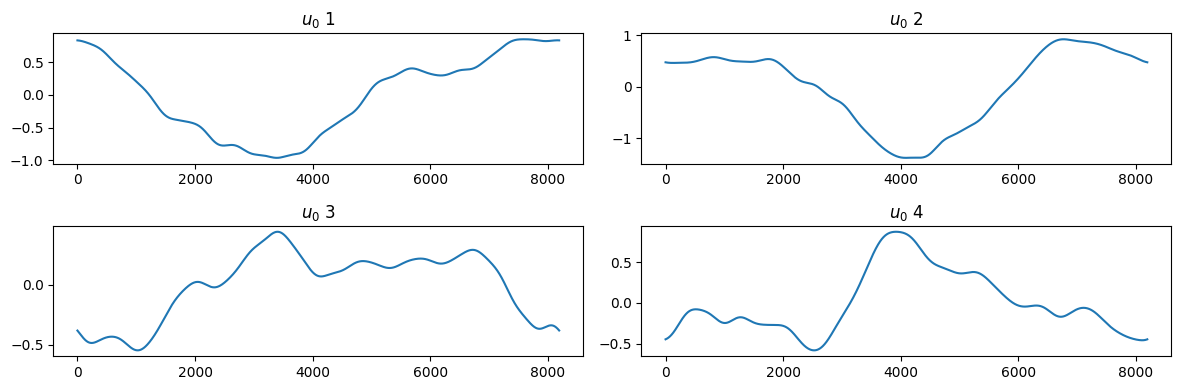

In [9]:
u0 = burgers_data[keys_list[3]]
plt.figure(figsize = (12,4))
for i in range(4):
    plt.subplot(2,2, i+1)
    plt.plot(u0[i], label = f"Initial condition {i+1}")
    plt.title(f"$u_0$ {i+1}")
plt.tight_layout()
plt.show()

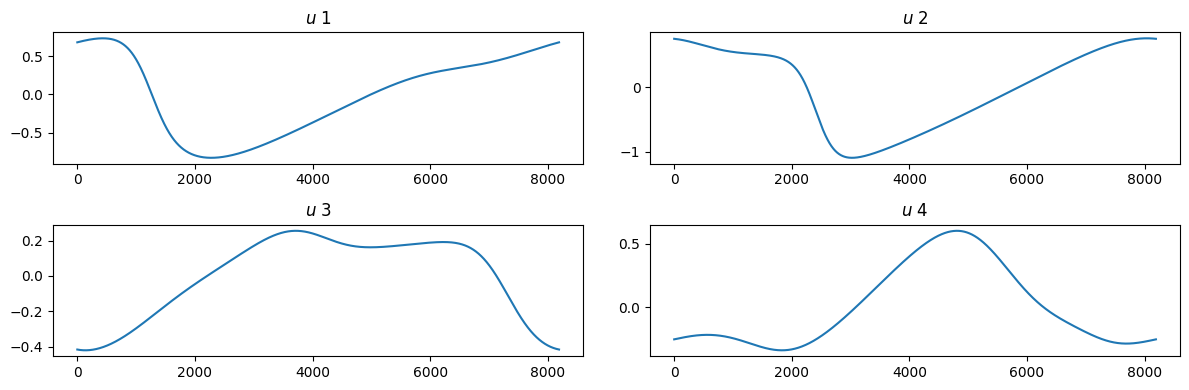

In [10]:
u = burgers_data[keys_list[-1]]
plt.figure(figsize = (12,4))
for i in range(4):
    plt.subplot(2,2, i+1)
    plt.plot(u[i], label = f"final prediction {i+1}")
    plt.title(f"$u$ {i+1}")
plt.tight_layout()
plt.show()

#### Preparing the dataset

In [11]:
def prepare_data(raw_data, sub, cfg, include_coord = True):
    #First we extract and downsample our input and output data
    input_data = torch.tensor(raw_data['a'], dtype = torch.float)[:,::sub]   #shape: (batch, Nx)
    target_data = torch.tensor(raw_data['u'], dtype = torch.float)[:,::sub]  #shape: (batch, Nx)
    #We need to assert that the shape matches our expectation
    expected_resolution = cfg.resolution_original//sub
    assert input_data.shape[1] == expected_resolution, f"Expected downsized sample {expected_resolution}, but got {input_data.shape[1]}"
    print(f'For the downsampled dataset --> input: {input_data.shape}, target: {target_data.shape}')
    print(f"input_data dtype: {input_data.dtype}, target_data dtype: {target_data.dtype}")
      
    #Next we split the downsampled dataset into training and testing
    x_train = input_data[:cfg.train_data_num, :]
    x_test = input_data[-cfg.test_data_num:, :]
    y_train = target_data[:cfg.train_data_num, :]
    y_test = target_data[-cfg.test_data_num:, :]
    print(f"After split --> x_train: {x_train.shape}, x_test: {x_test.shape}")

    #We need to reshape the data: (batch, N) --> (batch, N, 1), and then add grid information to ensure positional awareness

    x_train = x_train.unsqueeze(-1); x_test = x_test.unsqueeze(-1); y_train = y_train.unsqueeze(-1); y_test = y_test.unsqueeze(-1)
    print(f"After reshaping --> y_train: {y_train.shape}, y_test: {y_test.shape}")

    if include_coord: #To add the positional (grid) information
        grid = torch.linspace(0,1, cfg.resolution_original, dtype = torch.float).view(-1,1)
        grid = grid[::sub]
        x_train = torch.cat([x_train, grid.repeat(cfg.train_data_num, 1, 1)], dim = 2)
        x_test = torch.cat([x_test, grid.repeat(cfg.test_data_num, 1, 1)], dim = 2)
        print(f"After adding the grid --> x_train: {x_train.shape}, x_test: {x_test.shape}")

    #Creating the dataloader
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=cfg.batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=cfg.batch_size, shuffle=False)
    
    return train_loader, test_loader


In [12]:
class DataModule(pl.LightningDataModule):
  def __init__(self, cfg):
    super().__init__()
    self.cfg = cfg
    self.dataset_path =self.cfg.dataset_path

    self.train_loader = None
    self.test_loader = None

  def setup(self, stage = None):
    raw_data = loadmat(self.dataset_path)
    self.train_loader, self.test_loader = prepare_data(raw_data, self.cfg.sub, self.cfg, include_coord= True)
    print("Dataloaded sucessfully!")

  def train_dataloader(self):
    return self.train_loader

  def val_dataloader(self):
    return self.test_loader #Using test data as the validation

  def test_dataloader(self):
    return self.test_loader

data_module = DataModule(cfg)

In [13]:
data_module.setup()

For the downsampled dataset --> input: torch.Size([2048, 1024]), target: torch.Size([2048, 1024])
input_data dtype: torch.float32, target_data dtype: torch.float32
After split --> x_train: torch.Size([1000, 1024]), x_test: torch.Size([200, 1024])
After reshaping --> y_train: torch.Size([1000, 1024, 1]), y_test: torch.Size([200, 1024, 1])
After adding the grid --> x_train: torch.Size([1000, 1024, 2]), x_test: torch.Size([200, 1024, 2])
Dataloaded sucessfully!


### Training and Evaluation

In [12]:
class PlModel(pl.LightningModule):
  def __init__(self, cfg):
    super(PlModel, self).__init__()
    self.cfg = cfg
    self.model = FNO1d(self.cfg.modes, self.cfg.width)
    self.metrics = {'train_loss':[], 'test_loss':[], 'val_loss':[]}

  def forward(self, x):
    return self.model(x)
  def _common_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.model(x)
    loss = F.mse_loss(y_hat.view(-1,1), y.view(-1,1))
    return loss
      
  def training_step(self, batch, batch_idx):
    loss = self._common_step(batch, batch_idx)
    self.log('train_loss', loss, on_step =False, on_epoch = True, prog_bar = True, logger = True)
    self.metrics['train_loss'].append(loss.item())
    return loss

  def validation_step(self, batch, batch_idx):
    loss = self._common_step(batch, batch_idx)
    self.log('val_loss', loss, on_step =False, on_epoch = True, prog_bar = True, logger = True)
    self.metrics['val_loss'].append(loss.item())
    return loss

  def test_step(self, batch, batch_idx):
    loss = self._common_step(batch, batch_idx)
    self.log('test_loss', loss, on_step =False, on_epoch = True, prog_bar = True, logger = True)
    self.metrics['test_loss'].append(loss.item())
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr = self.cfg.lr, weight_decay = self.cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = self.cfg.step_size, gamma = self.cfg.gamma)
    return [optimizer], [scheduler]

  def evaluate_at_diff_resolutions(self, raw_data, resolution_test_list):
    for resolution_test in resolution_test_list:
      print(f'Testing Resolution: {resolution_test}')
      sub = self.cfg.resolution_original//resolution_test
      _,test_loader = prepare_data(raw_data, sub, self.cfg, include_coord = True)
        
      self.eval()
      with torch.no_grad():
          for x,y in test_loader:
            x,y = x.to(self.device), y.to(self.device)
            pred = self(x)
            
            # Plot prediction vs ground truth
            plt.figure(figsize=(8, 4))
            plt.plot(pred[0].cpu().numpy(), 'r', label='Prediction')
            plt.plot(y[0].cpu().numpy(), 'b', label='Ground Truth')
            plt.scatter(np.arange(resolution_test), pred[0].cpu().numpy(), c='r', s=10)
            plt.scatter(np.arange(resolution_test), y[0].cpu().numpy(), c='b', s=10)
            plt.title(f'FNO1d Prediction vs Ground Truth @ Resolution {resolution_test}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            break  # only plot first batch

For the downsampled dataset --> input: torch.Size([2048, 1024]), target: torch.Size([2048, 1024])
input_data dtype: torch.float32, target_data dtype: torch.float32
After split --> x_train: torch.Size([1000, 1024]), x_test: torch.Size([200, 1024])
After reshaping --> y_train: torch.Size([1000, 1024, 1]), y_test: torch.Size([200, 1024, 1])
After adding the grid --> x_train: torch.Size([1000, 1024, 2]), x_test: torch.Size([200, 1024, 2])
Dataloaded sucessfully!


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/checkpoints_burgers exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

For the downsampled dataset --> input: torch.Size([2048, 1024]), target: torch.Size([2048, 1024])
input_data dtype: torch.float32, target_data dtype: torch.float32
After split --> x_train: torch.Size([1000, 1024]), x_test: torch.Size([200, 1024])
After reshaping --> y_train: torch.Size([1000, 1024, 1]), y_test: torch.Size([200, 1024, 1])
After adding the grid --> x_train: torch.Size([1000, 1024, 2]), x_test: torch.Size([200, 1024, 2])
Dataloaded sucessfully!


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │  0.00022980602807365358   │
└───────────────────────────┴───────────────────────────┘

Testing Resolution: 64
For the downsampled dataset --> input: torch.Size([2048, 64]), target: torch.Size([2048, 64])
input_data dtype: torch.float32, target_data dtype: torch.float32
After split --> x_train: torch.Size([1000, 64]), x_test: torch.Size([200, 64])
After reshaping --> y_train: torch.Size([1000, 64, 1]), y_test: torch.Size([200, 64, 1])
After adding the grid --> x_train: torch.Size([1000, 64, 2]), x_test: torch.Size([200, 64, 2])


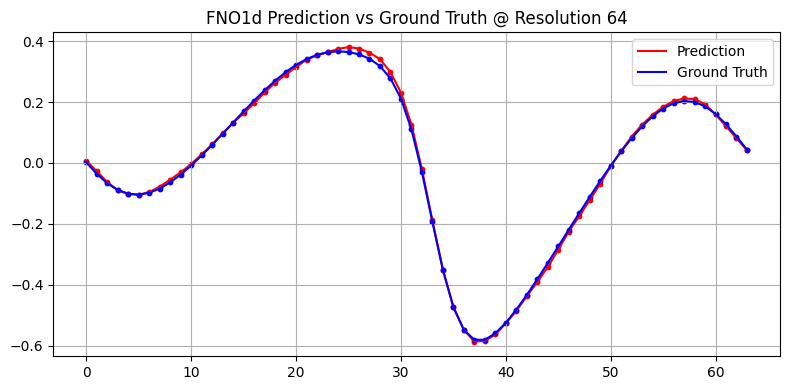

Testing Resolution: 256
For the downsampled dataset --> input: torch.Size([2048, 256]), target: torch.Size([2048, 256])
input_data dtype: torch.float32, target_data dtype: torch.float32
After split --> x_train: torch.Size([1000, 256]), x_test: torch.Size([200, 256])
After reshaping --> y_train: torch.Size([1000, 256, 1]), y_test: torch.Size([200, 256, 1])
After adding the grid --> x_train: torch.Size([1000, 256, 2]), x_test: torch.Size([200, 256, 2])


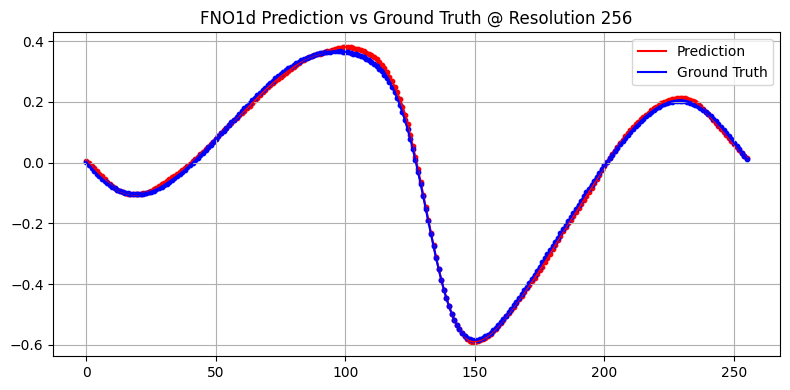

Testing Resolution: 1024
For the downsampled dataset --> input: torch.Size([2048, 1024]), target: torch.Size([2048, 1024])
input_data dtype: torch.float32, target_data dtype: torch.float32
After split --> x_train: torch.Size([1000, 1024]), x_test: torch.Size([200, 1024])
After reshaping --> y_train: torch.Size([1000, 1024, 1]), y_test: torch.Size([200, 1024, 1])
After adding the grid --> x_train: torch.Size([1000, 1024, 2]), x_test: torch.Size([200, 1024, 2])


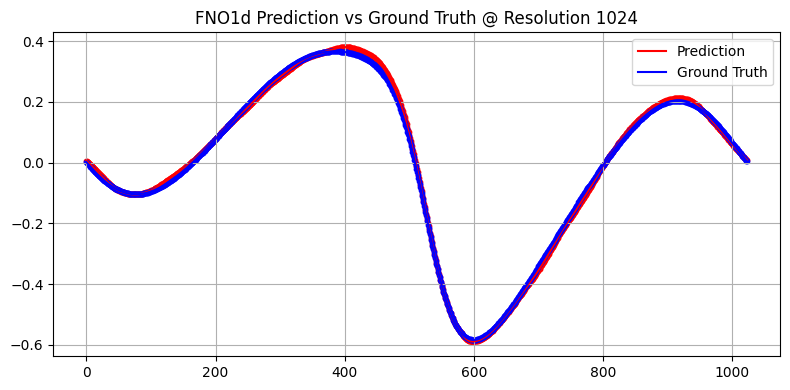

In [13]:
#Training the model
model = PlModel(cfg)

checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = cfg.checkpoint_dir,
    filename = 'fno-{epoch:02d}-{val_loss:.2f}',
    save_top_k = 1,
    mode = 'min'
)

trainer = pl.Trainer(
    max_epochs = cfg.num_epoch,
    callbacks = [checkpoint_callback],
    accelerator = 'gpu',
    devices = 1,
    enable_progress_bar = True
)

#Train the model
trainer.fit(model, data_module)
#Test the model
#model = PlModel.load_from_checkpoint(checkpoint_callback.best_model_path, cfg = cfg) #Load the best checkpoint before testing
trainer.test(model, data_module.test_dataloader())

#Evaluating the model at different resolutions
raw_data = loadmat(cfg.dataset_path)  # Ensure this is loaded correctly
resolution_test_list = [64, 256, 1024]
model.evaluate_at_diff_resolutions(raw_data, resolution_test_list)

### Training and Validation Loss plot

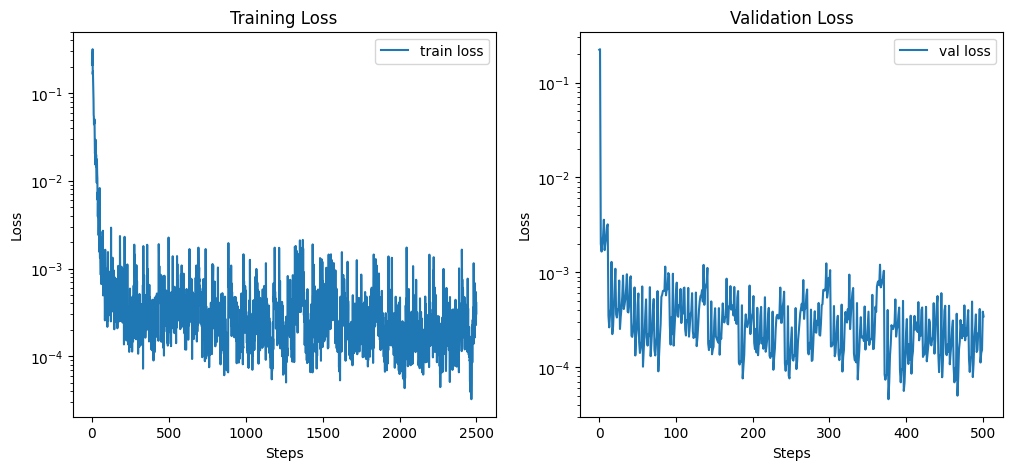

In [15]:
# plot the training loss and validation loss in two subplots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model.metrics['train_loss'], label='train loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.metrics['val_loss'], label='val loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Validation Loss')
plt.legend()
plt.show()

## Reference

* Sci-ML-Book: https://github.com/xiaoyuxie-vico/Sci-ML-Book/blob/main/FNO/FNO-1D/FNO-1D.ipynb